### Project 1
**3180105843 汪奕晨**

用遗传算法近似求解TSP

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import time

In [16]:
class tsp_genetic():
    def __init__(self, Dots, group_size = 1000, k = (0.5, 0.3, 0.25, 0.15), p_tuple=(0.4,0.4,0.2)):
        if Dots.shape[0] != 2:
            raise ValueError('输入的点并非二维！')
        self.Dots = Dots # 点阵
        self.n = Dots.shape[1] # 点的数目
        # 三个初值 其实作用不大
        self.set_p(p_tuple)
        self.k = k # 自适应方法的参数
        self.min_rec = np.array([]) # 记录每一次迭代的最短距离
        self.mean_rec = np.array([]) # 记录每一次迭代的平均距离
        self.best_ans = np.array([]) # 记录最优解
        
        # 融入SA算法
        self.iter_per_t = 10

        self.iter = 1
        self.t = 10

        self.Graph = np.zeros((self.n,self.n)) # 距离矩阵
        # 生成距离矩阵 由于只需要在初始化时计算，就采用更直观的循环而非向量化实现了
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    self.Graph[i][j] = self.Graph[j][i] =  np.sqrt( (Dots[0,i] - Dots[0,j])**2 + (Dots[1,i] - Dots[1,j])**2 ) 
        
        self.reset_group(group_size)
        
    # 重置概率
    def set_p(self, p_tuple):
        if np.sum(p_tuple) != 1:
            print(p_tuple)
            raise ValueError('三个概率的和不为1！')

        self.pr = p_tuple[0]
        self.pc = p_tuple[1]
        self.pm = p_tuple[2]
    
    # 重置种群
    def reset_group(self, group_size=None, const=False):
        '''
        group_size: number of groups
        const: back to original group if True, else reset randomly and renew const_init_group
        '''
        if const:
            self.Group = self.const_init_group
        else:
            if group_size:
                self.group_size = group_size
            # 向量化实现生成种群
            # 生成种群,每行为一个n-排列
            x = np.arange(self.n)
            x = x.reshape(1,-1) # 变至二维的
            self.Group = np.repeat(x, self.group_size, axis=0) # 复制若干次
            np.apply_along_axis(np.random.shuffle, 1, self.Group) # 对每一行打乱

            # 以下注释掉的为非向量化的方法
            # self.Group = np.zeros((self.group_size, self.n)) # 每行为一个个体
            # for i in range(self.group_size):
            #     np.random.shuffle(x)
            #     self.Group[i] = x
            self.const_init_group = self.Group

        self.min_rec = np.array([])
        self.mean_rec = np.array([])
        self.best_ans = np.array([])
        self.group_variety = np.array([])

        self.iter = 1
        self.t = 10

        self.distance = self.gen_distance(self.Group) # 记录当前种群每个个体对应的距离
        self.fitness = self.gen_fitness(self.Group) # 记录当前种群每个个体的适合度


    # 随机抽取
    def rand_choose(self, pdf, times = 1):
        if len(pdf) != self.group_size: # 需抽取的总数
            raise ValueError('pdf的长度与group_size不一致')

        pdf_normed = pdf/np.sum(pdf)
        n = self.group_size
        c = np.arange(n) # 抽取的值列表
        # choice的第三个参数为False表明抽取不放回
        return np.random.choice(c,times, False, p=pdf_normed.ravel())  

    # 计算距离
    def gen_distance(self, paths):
        if paths.shape[1] != self.n:
            raise ValueError('输入的路径与矩阵维度不一致')

        d = np.zeros(paths.shape[0])
        for j in range(paths.shape[0]):
            path = paths[j]
            for i in range(self.n -1):
                d[j] += self.Graph[int(path[i])][int(path[i+1])]
            d[j] += self.Graph[int(path[-1])][int(path[0])]
        return d


    # 计算适合度
    def gen_fitness(self, paths):
        d = self.gen_distance(paths)
        return np.max(d) - d 


    # 变异方法
    def gen_mutation(self, path):
        if len(path) != self.n:
            raise ValueError('path的长度与节点数量不同')
        nodes = np.random.choice(self.n, 2, False)
        node_1 = min(nodes)
        node_2 = max(nodes)
        return np.hstack((path[0: node_1], path[node_2:node_1:-1], path[node_1:node_1 + 1], path[node_2 + 1:]))


    def mutation_over(self, times, SA):
        # times 为变异的数量
        idx = self.rand_choose(self.fitness ,times = times)
        individuals = self.Group[idx]
        individuals_after_mutation = np.zeros((times, self.n))
        # 这里可以采用Apply方法向量化实现，但我比较懒
        for i in range(times):
            individuals_after_mutation[i] = self.gen_mutation(individuals[i])
        
        if SA:
            old_dist = self.gen_distance(individuals)
            new_dist = self.gen_distance(individuals_after_mutation)
            c = self.boltzman_choose(-old_dist, -new_dist, self.t) # 符号表明最小化距离
            individuals_after_mutation[~c] = individuals[~c]

        return individuals_after_mutation


    # 交叉方法
    def gen_children(self, paths, method):
        if paths.shape[0] != 2:
            raise ValueError('超过两个路径的输入！' + str(paths.shape[0]))
        elif paths.shape[1] != self.n:
            raise ValueError('路径长度与节点数目不同！')
        
        nodes = np.random.choice(self.n, 2, False)
        node_1 = min(nodes)
        node_2 = max(nodes)
        crossed_path = paths.copy()
        # 三种交叉方法
        if method == 'partial-mapped':
            tsp_genetic.cross_partial_mapped(crossed_path[0], paths[1], node_1, node_2)
            tsp_genetic.cross_partial_mapped(crossed_path[1], paths[0], node_1, node_2)
        
        elif method == 'order':
            tsp_genetic.cross_order(crossed_path[0], paths[1], node_1, node_2)
            tsp_genetic.cross_order(crossed_path[1], paths[0], node_1, node_2)

        elif method == 'position-based':
            L = np.arange(self.n)
            nodes = np.random.choice(L, self.n//2, False)
            mask_1 = np.in1d(paths[0], nodes)
            mask_2 = np.in1d(paths[1], nodes)
            crossed_path[0][~mask_1] = paths[1][~mask_2]
            crossed_path[1][~mask_2] = paths[0][~mask_1]

        else:
            raise ValueError('wrong method!')

        return crossed_path


    def cross_over(self, times, method, SA):
        # 交叉得到的下一代
        individuals_after_cross = np.zeros((times, self.n))
        k = 0
        parents_all = self.Group[self.rand_choose(self.fitness, times = times+1 if times%2 else times)]
        while k < times:
            # idx = self.rand_choose(self.fitness ,times = 2)
            # parents = self.Group[idx]
            parents = parents_all[k:k+2] 
            children = self.gen_children(parents, method=method)
            individuals_after_cross[k] = children[0]
            k += 1
            if k == times:
                break
            individuals_after_cross[k] = children[1]
            k += 1
        # 引入退火选择
        if SA:
            parents_all = parents_all[:times]
            old_dist = self.gen_distance(parents_all)
            new_dist = self.gen_distance(individuals_after_cross)
            c = self.boltzman_choose(-old_dist, -new_dist, self.t)
            individuals_after_cross[~c] = parents_all[~c]

        return individuals_after_cross

    # 选择/复制算子
    def select_over(self, nr):
        # 2-锦标赛法 两组进行竞赛选取表现最优的个体
        group1 = self.Group[self.rand_choose(self.fitness ,times = nr)]
        group2 = self.Group[self.rand_choose(self.fitness ,times = nr)]
        dist1 = self.gen_distance(group1)
        dist2 = self.gen_distance(group2)
        left = dist1 < dist2 # 选择距离较小，表现较好的
        return np.vstack((group1[left],group2[~left]))
        # return self.Group[self.rand_choose(self.fitness ,times = nr)] # 弃用的轮盘赌选择

    # # 在复制交叉突变前先进行退火
    # def SA_in_GA(self, SA=False):
    #     if SA:
    #         np.apply_along_axis(self.SA_per, 1, self.Group)
    #         self.distance = self.gen_distance(self.Group) # 记录当前种群每个个体对应的距离
    #         self.fitness = self.gen_fitness(self.Group) # 记录当前种群每个个体的适合度
    #     self.iter += 1
    #     self.t *= (1 - 1 / (50 + np.log(self.iter + 1))) # 更新温度


    # def SA_per(self, path):
    #     k = 0
    #     dist = self.gen_distance(path.reshape(1,-1))[0]
    #     while k < self.iter_per_t:
    #         new_path = self.gen_mutation(path)
    #         new_dist = self.gen_distance(new_path.reshape(1,-1))[0]
    #         if new_dist <= dist:
    #             path[:] = new_path[:]
    #         else:
    #             h = np.exp((dist - new_dist)/self.t)
    #             U = np.random.rand()
    #             if (U < h):
    #             # x = y.copy()
    #                 path[:] = new_path[:]
    #                 dist = new_dist # 这里优化了更新dx的方法
    #         k = k + 1
    #     # self.t *= (1 - 1 / (50 + np.log(i + 1))) # 更新温度
        
    @staticmethod
    def boltzman_choose(old, new, t):
        if len(old) != len(new):
            raise ValueError('比较的向量长度不同 {}, {}'.format(len(old), len(new)))
        L = len(old)
        h = np.exp(-(old-new)/t)
        u = np.random.rand(L)
        return u<h

    # 生成下一代
    def reproduce(self, method, auto, SA, UPD):
        pt = np.array([self.pr, self.pc, self.pm])
        choose = np.random.choice(np.arange(3), self.group_size, True, p=pt)

        nr = np.sum(choose == 0)
        nc = np.sum(choose == 1)
        nm = np.sum(choose == 2)
        new_group = self.Group.copy()
        # self.SA_in_GA(SA=SA)
        # 复制得到的下一代
        new_group[:nr] = self.select_over(nr)
        # 交叉得到的
        new_group[nr: nr+nc] = self.cross_over(nc, method=method, SA=SA)
        # 突变得到的
        new_group[nr+nc:] = self.mutation_over(nm, SA=SA)

        new_distance = self.gen_distance(new_group)
        new_fitness = self.gen_fitness(new_group)
        
        if auto:
            # 自适应更改pc pm pr
            d_max = np.max(new_distance)
            d_min = np.min(new_distance)
            d_mean = np.mean(new_distance)

            dc_new = np.sum(new_distance[nr: nr+nc]) / nc if nc != 0 else d_mean
            dm_new = np.sum(new_distance[nr+nc: ]) / nm if nm != 0 else d_mean
            # print(dc_new, dm_new, d_max, d_min, d_mean)
            self.pc = self.k[0] if dc_new >= d_mean else self.k[0]-self.k[1]*(dc_new - d_min)/(d_mean - d_min)
            self.pm = self.k[2] if dm_new >= d_mean else self.k[2]-self.k[3]*(dm_new - d_min)/(d_mean - d_min)
            self.pr = 1 - self.pc - self.pm

        # update
        # 强制更新种群 防早熟
        if UPD:
            unique_group = np.unique(new_group, axis=0)
            # mask = np.in1d(self.Group.view(dtype=','.join(['i']*self.n)), unique_group.view(dtype=','.join(['i']*self.n)))
            # temp_fit = self.fitness.copy()
            # print(temp_fit)
            # temp_fit[mask] = 0
            # print(mask)
            # print(temp_fit)
            # add_group = self.Group[self.rand_choose(temp_fit, self.group_size - b.shape[0])]
            x = np.arange(self.n)
            x = x.reshape(1,-1) # 变至二维的
            if self.group_size == unique_group.shape[0]:
                self.Group = unique_group
            else:
                add_group = np.repeat(x, self.group_size - unique_group.shape[0], axis=0) # 复制若干次
                np.apply_along_axis(np.random.shuffle, 1, add_group) # 对每一行打乱
                self.Group = np.vstack((unique_group, add_group))
        else:
            self.Group = new_group

        self.fitness = self.gen_fitness(self.Group)
        self.distance = self.gen_distance(self.Group)
                
    
    # 遗传算法主体
    # 由于会更新实例内的Group 故可以通过不断evolute在原有基础上进行再次迭代
    def evolute(self, generations, method = 'partial-mapped', auto=True, SA=False, UPD=True):
        start_time = time.time()
        record = np.zeros(generations)
        mean_dist = np.zeros(generations)
        group_varieties = np.zeros(generations)
        dist_best = self.min_rec[-1] if self.min_rec.shape[0] != 0 else 65535
        individual_best = self.best_ans if self.best_ans.shape[0] else np.zeros(self.n)
        percentage = 0.05
        for i in range(generations):
            self.reproduce(method = method, auto=auto, SA=SA, UPD=UPD)
            if np.min(self.distance) < dist_best:
                dist_best = np.min(self.distance)
                individual_best = self.Group[np.where(self.distance == dist_best)[0][0]]
            record[i] = dist_best
            mean_dist[i] = np.mean(self.distance)
            b = np.unique(self.Group, axis=0)
            group_varieties[i] = b.shape[0] # 更新种群多样性

            if i >= percentage * generations:
                print('{0:02.0f}%'.format(percentage*100), end=' ')
                percentage += 0.05

            # 更新退火温度
            if SA and i%self.iter_per_t:
                self.iter += 1
                self.t *= (1 - 1 / (50 + np.log(self.iter + 1))) # 更新温度

           # 防早熟策略在reproduce中


        end_time = time.time()
        self.min_rec = np.append(self.min_rec, record)
        self.mean_rec = np.append(self.mean_rec, mean_dist)
        self.group_variety = np.append(self.group_variety, group_varieties)
        self.best_ans = individual_best
        print('\nrun time = {}'.format(end_time - start_time))
        return record, mean_dist, individual_best.astype(int)


    @staticmethod
    def cross_partial_mapped(path_1, path_2, node_1, node_2):
        # 传入可变对象直接修改
        if node_1 > node_2:
            raise ValueError('节点顺序反啦！')
        if len(path_1) != len(path_2):
            raise ValueError('path长度不一致！')
    
        # cross_part_1 = path_1[node_1 : node_2 + 1].copy()
        cross_part_2 = path_2[node_1 : node_2 + 1].copy()
        # node_len = node_2 - node_1 + 1
        
        for i in range(len(path_1)):
            if not (node_1 <= i <= node_2):
                this_node = path_1[i]
                while this_node in cross_part_2:
                    idx = np.where(path_2 == this_node)[0][0]
                    this_node = path_1[idx]
                path_1[i] = this_node

        path_1[node_1: node_2 + 1] = path_2[node_1: node_2 + 1]


    @staticmethod
    def cross_order(path_1, path_2, node_1, node_2):
        # 传入可变对象直接修改
        if node_1 > node_2:
            raise ValueError('节点顺序反啦！')
        if len(path_1) != len(path_2):
            raise ValueError('path长度不一致！')

        cross_part_1 = path_1[node_1 : node_2 + 1].copy()
        # setdiff1d 会自动排序
        # left_part_1 = np.setdiff1d(path_2, cross_part_1)
        # 使用掩码解决自动排序的问题
        left_part_1 = path_2[~np.in1d(path_2,cross_part_1)]
        path_1[:node_1] = left_part_1[:node_1]
        path_1[node_2 + 1 :] = left_part_1[node_1 :]


    # 绘图函数
    def plot_cities(self, path=None, savepath=None):
        if path is None:
            path = self.best_ans
        if len(path) != self.n:
            raise ValueError('路径长度错误！')
        plt.figure()
        for i in range(self.n - 1):
            plt.plot( self.Dots[0][[path[i], path[i+1]]], self.Dots[1][[path[i], path[i+1]]], 'b*-')
        plt.plot(self.Dots[0][[path[-1], path[0]]], self.Dots[1][[path[-1], path[0]]], 'b*-') 
        plt.title('GA: best tsp path')
        if savepath:
            plt.savefig(savepath)
        plt.show()

    def plot_record(self, type=1, savepath=None):
        if type == 1:
            y, title, ylabel = (self.min_rec, 'GA: Shortest distance - iterations Graph', 'Shortest distance in the population') 
        elif type == 2:
            y, title, ylabel = (self.mean_rec, 'GA: Average distance - iterations Graph', 'Average distance in the population')
        else:
            y, title, ylabel = (self.group_variety, 'GA: Group Variety - iterations Graph', 'Group Variety in the population')
        
        n = y.shape[0]
        plt.figure()
        plt.plot(np.arange(1, n+1), y)
        plt.title(title)
        plt.xlabel('iterations')
        plt.ylabel(ylabel)
        if savepath:
            plt.savefig(savepath)
        plt.show()


In [17]:
class tsp_anneal():
    def __init__(self, city, t0=20, maxit=2000, iter_time=600):
        self.city = city
        self.n = dots.shape[1]
        self.set_params(t0, maxit, iter_time)
        # self.ans 

    def set_params(self, t0, maxit, iter_time):
        self.t0 = t0
        self.maxit = maxit
        self.iter_time = iter_time
        

    def tspsa(self, params=None):
        # 在有些不需要copy的地方，只传地址会更快
        if params:
            self.set_params(*params)
        k = 0
        t = self.t0
        x = self.city
        dx = self.distance(x)
        ds = dx
        min_dist = np.zeros(self.iter_time)
        # run_time = np.zeros(self.iter_time)
        start_time = time.time()
        percent = 0.05
        for i in range(self.iter_time):
            while (k < self.maxit):
                if (dx < ds):
                    xs = x
                    ds = dx
                y = self.swapcities(x)
                dy = self.distance(y)
                h = min(1, np.exp(-(dy - dx)/t))
                U = np.random.rand()
                if (U < h):
                    # x = y.copy()
                    x = y
                    dx = dy # 这里优化了更新dx的方法
                k = k + 1
            t *= (1 - 1 / (50 + np.log(i + 1)))
            k = 0
            min_dist[i] = ds
            if i > percent * self.iter_time:
                print('{0:02.0f}%'.format(percent*100), end=' ') # 打印以追踪进度
                percent += 0.05
            # mid_time = time.time()
            # run_time[i] = mid_time - start_time

        end_time = time.time()
        print('\nrun time: {0:}'.format(end_time - start_time))
        self.best_ans = xs
        self.min_dist = min_dist
        # self.run_time = run_time
        return min_dist, xs


    def swapcities(self, cityXY):
        nodes = np.random.choice(self.n, 2, False)
        city_1 = min(nodes)
        city_2 = max(nodes)

        s = np.hstack((cityXY[:,0: city_1], cityXY[:,city_2:city_1:-1], cityXY[:,city_1:city_1 + 1], cityXY[:,city_2 + 1:]))
        # 这里使用了加一使得得到的矩阵的列宽为1，否则使用.shape会输出空的列宽，可以防止hstack报错 'dimention 不一致'
        return s

    
    @staticmethod
    def dis2(x, y):
        return np.sqrt( (x-y)[0] * (x-y)[0] + (x-y)[1] * (x-y)[1]  )


    @staticmethod
    def distance(city):
        dd = tsp_anneal.dis2(city[:,:-1], city[:, 1:])
        d = np.sum(dd)
        #使用向量化可以极大地提高计算速度
        d += tsp_anneal.dis2(city[:, -1], city[:, 0])
        return d


    def plotcities(self, city=None, savepath=None):
        cityXY = city if city else self.best_ans
        try:
            plt.figure()
            plt.plot(cityXY[0, :], cityXY[1, :], 'b*')
            plt.plot(cityXY[0, :], cityXY[1, :], 'b')
            plt.plot([cityXY[0, -1:], cityXY[0, 0]], [cityXY[1, -1:], cityXY[1, 0]], 'b')
            plt.title('SA: best tsp path')
            if savepath:
                plt.savefig(savepath)
            plt.show()
        except:
            raise ValueError('no figure to plot')

    def plot_record(self, savepath=None):
        y = self.min_dist
        n = y.shape[0]
        x = np.arange(1, n+1)
        plt.figure()
        plt.plot(x, y, 'r-')
        plt.xlabel('iterations')
        plt.ylabel('Minimum distance')
        plt.title('SA: Minimum distance - iterations Graph')
        if savepath:
            plt.savefig(savepath)
        plt.show()

In [18]:
class testmodule():
    def __init__(self, dots=None, size=None):
        '''
        size has a higher priviledge than dots
        '''
        self.tsp_GA = None
        self.tsp_SA = None
        if size:
            self.set_bysize(size)
        elif dots:
            self.set_bydots(dots)

    def set_bydots(self, dots, obj='ALL'):
        if obj == 'ALL' or obj == 'GA':
            self.tsp_GA = tsp_genetic(dots, group_size = 1)
        if obj == 'ALL' or obj == 'SA':
            self.tsp_SA = tsp_anneal(dots)

    def set_bysize(self, tsp_size, obj='ALL'):
        dots = np.random.rand(2, tsp_size)
        if obj == 'ALL' or obj == 'GA':
            self.tsp_GA = tsp_genetic(dots, group_size = 1)
        if obj == 'ALL' or obj == 'SA':
            self.tsp_SA = tsp_anneal(dots)

    def GA_cross_method_test(self, group_size, iterations, savepath=None):
        methods = ['partial-mapped', 'order', 'position-based']
        record = np.zeros((3, iterations))
        self.tsp_GA.reset_group(group_size)

        for i in range(3):
            self.tsp_GA.reset_group(const=True)
            record[i] = self.tsp_GA.evolute(iterations, method=methods[0])[0]
        x = np.arange(1, iterations+1)
        plt.figure()
        plt.plot(x, record[0], 'r-', label=methods[0])
        plt.plot(x, record[1], 'g-', label=methods[1])
        plt.plot(x, record[2], 'b-', label=methods[2])
        plt.legend()
        plt.xlabel('iterations')
        plt.ylabel('Minimum distance')
        plt.title('Comparison of three cross-over methods')
        if savepath:
            plt.savefig(savepath)
        plt.show()


    def GA_auto_test(self, group_size, iterations, savepath=None):
        self.tsp_GA.reset_group(group_size)

        record1 = self.tsp_GA.evolute(iterations, auto=True)[0]
        self.tsp_GA.reset_group(const=True)
        record2 = self.tsp_GA.evolute(iterations, auto=False)[0]

        x = np.arange(1, iterations+1)
        plt.figure()
        plt.plot(x, record1, 'r-', label='auto = True')
        plt.plot(x, record2, 'g-', label='auto = False')
        plt.legend()
        plt.xlabel('iterations')
        plt.ylabel('Minimum distance')
        plt.title('Comparison of auto-p methods')
        if savepath:
            plt.savefig(savepath)
        plt.show()

    def GA_perf_test(self, group_size, iterations, tsp_size=None, savefolder=None, merge=False, mergesave=None, SA=False):
        '''
        input params must be lists
        '''
        if len(group_size) != len(iterations):
            raise ValueError('dimention does not match!')
        if tsp_size:
            if len(group_size) != len(tsp_size):
                raise ValueError('dimention for tsp_size does not match!')
        for i in range(len(group_size)):
            if tsp_size is not None:
                if self.tsp_GA is None: 
                    self.set_bysize(tsp_size[i], 'GA')
                elif tsp_size[i] != self.tsp_GA.n:
                    self.set_bysize(tsp_size[i], 'GA')
                    
            if group_size[i] != self.tsp_GA.group_size:
                self.tsp_GA.reset_group(group_size[i]) 
            else:
                self.tsp_GA.reset_group(const=True)

            min_rec, mean_rec, res = self.tsp_GA.evolute(iterations[i], SA=SA)
            
            postfix = str(i+1)
            SAfix = 'SA' if SA else ''

            x = np.arange(1, iterations[i]+1)  
            if not merge:  
                postfix = ''       
                plt.figure()
            plt.plot(x, min_rec, label='min distance' + postfix)
            # 注释掉下行可以取消输出mean_rec
            # plt.plot(x, mean_rec, label='avg distance' + postfix)
            plt.xlabel('iterations')
            plt.ylabel('Distance')
            plt.legend()
            plt.title('GA ' + SAfix + ' algorithm performance')
            if not merge:
                if savefolder:
                    plt.savefig(savefolder + 'GA' + SAfix + '_perf_{}_{}_{}.jpg'.format(tsp_size[i], group_size[i], iterations[i]))
                plt.show()
                self.tsp_GA.plot_cities(path=res, savepath=savefolder + 'GA' + SAfix + '_res_{}_{}_{}.jpg'.format(tsp_size[i], group_size[i], iterations[i]) if savefolder else None)

        if merge:
            if mergesave:
                plt.savefig(mergesave)
            plt.show()


    def compare_GASA_test(self, group_size, iterations, savepath=None):
        self.tsp_GA.reset_group(group_size)
        record_GA, mean_rec_GA, res_GA = self.tsp_GA.evolute(iterations)
        record_SA, res_SA = self.tsp_SA.tspsa(params=(10, 600, iterations))
        self.tsp_GA.reset_group(const=True)
        record_GASA, mean_rec_GASA, res_GASA = self.tsp_GA.evolute(iterations, SA=True)
        x = np.arange(1, iterations+1)

        plt.figure()
        plt.plot(x, record_GA, 'r.-', label='GA')
        plt.plot(x, record_SA, 'b.-', label='SA')
        plt.plot(x, record_GASA, 'g.-', label='GA promoted by SA')
        plt.xlabel('iterations')
        plt.ylabel('Minimum distance')
        plt.legend()
        plt.title('Performance Comparison')
        if savepath:
            plt.savefig(savepath)
        plt.show()


In [19]:
tsp_size = 200
group_size = 200
dots = np.random.rand(2, tsp_size)
tsp = tsp_genetic(dots, group_size = group_size)

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 8535.053295373917


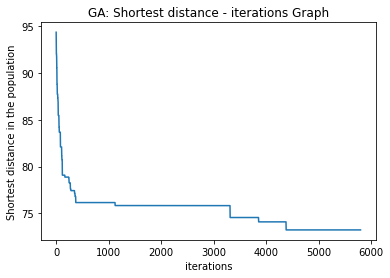

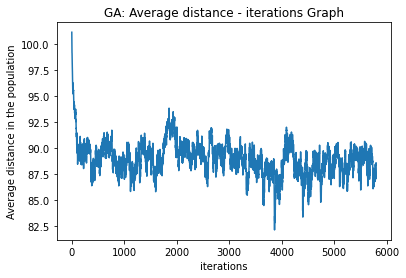

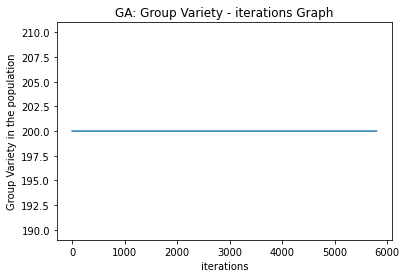

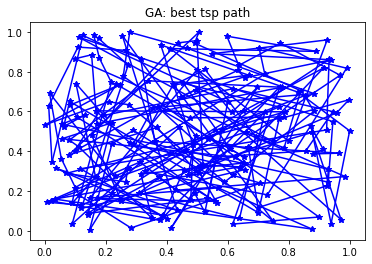

In [20]:
tsp.evolute(5800, SA=False, UPD=True)
tsp.plot_record(1)
tsp.plot_record(2)
tsp.plot_record(3)
tsp.plot_cities()

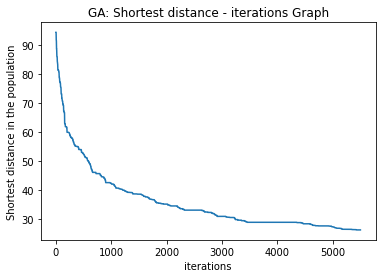

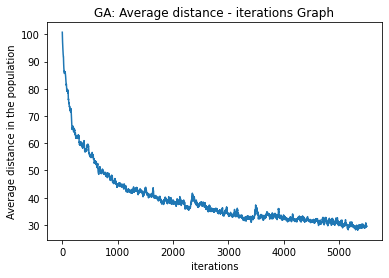

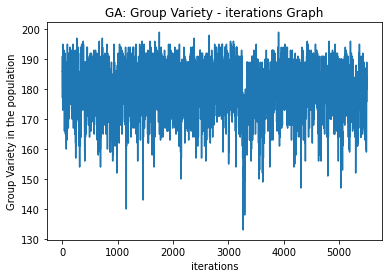

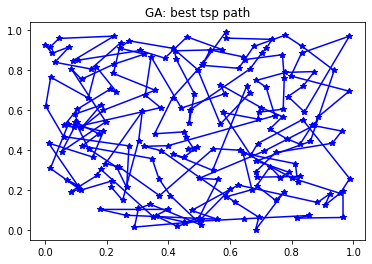

In [12]:
# tsp.evolute(200, SA=True)
tsp.plot_record(1)
# tsp.plot_record(2)
# tsp.plot_record(3)
# tsp.plot_cities()

In [ ]:
tsp.reset_group(const=True)
tsp.evolute(2000)
tsp.plot_record(1)
tsp.plot_record(2)
# tsp.plot_record(3)
tsp.plot_cities()

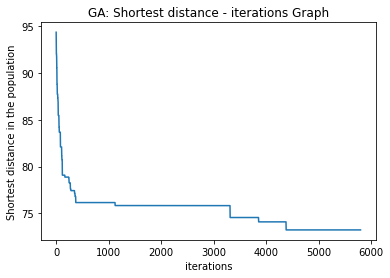

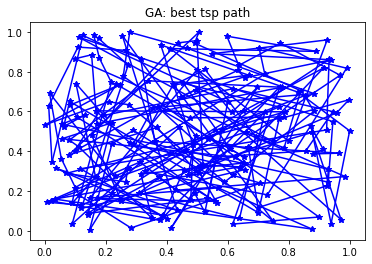

In [21]:
tsp.plot_record(1, savepath='./figure/GAUPD_perf_200_200_5800')
tsp.plot_cities(savepath='./figure/GAUPD_res_200_200_5800')

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 785.8876428604126


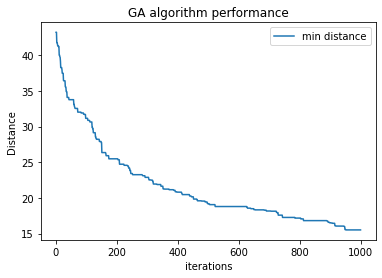

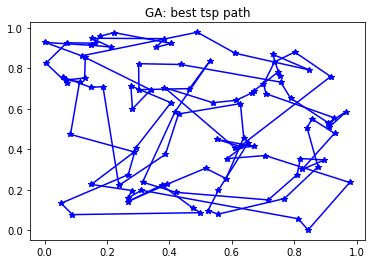

In [146]:
tsp_size = [50]
group_size = [200]
iterations = [800]

# 200的有效性测试
test = testmodule()
test.GA_perf_test(group_size, iterations, tsp_size, savefolder='./figure/')

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 624.7492442131042


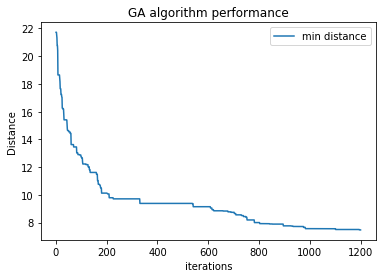

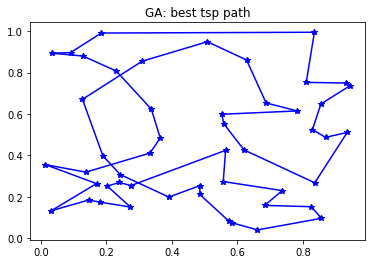

In [151]:
tsp_size = [50]
group_size = [200]
iterations = [1200]

# 50的有效性测试
test = testmodule()
test.GA_perf_test(group_size, iterations, tsp_size, savefolder='./figure/')

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 51.82349443435669


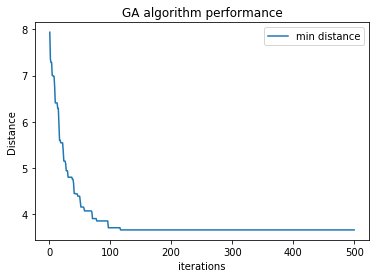

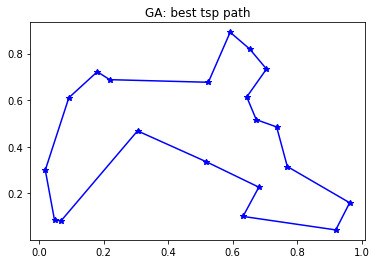

In [143]:
tsp_size = [20]
group_size = [100]
iterations = [500]

# 20的有效性测试
test = testmodule()
test.GA_perf_test(group_size, iterations, tsp_size, savefolder='./figure/')

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 2679.37079000473


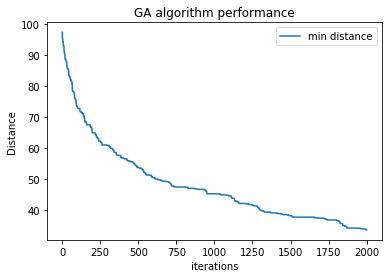

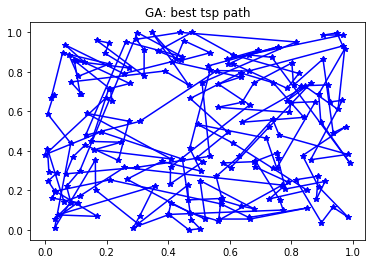

In [142]:
tsp_size = [200]
group_size = [200]
iterations = [2000]

# 200的有效性测试
test = testmodule()
test.GA_perf_test(group_size, iterations, tsp_size, savefolder='./figure/')

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 204.33138036727905


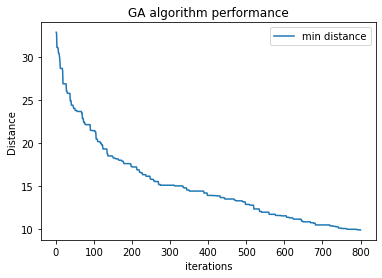

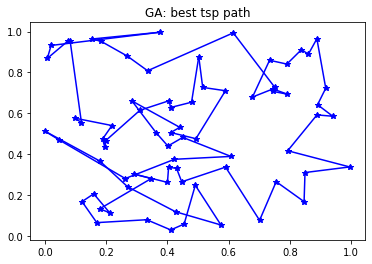

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 423.4013304710388


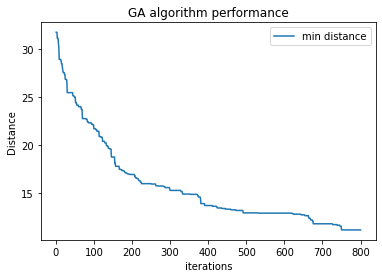

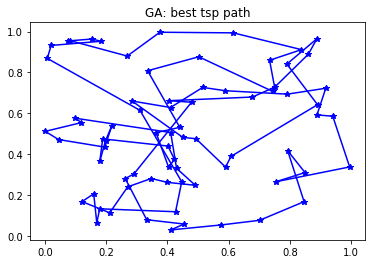

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 624.2843916416168


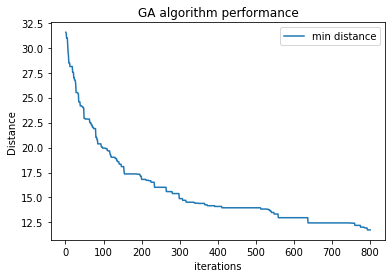

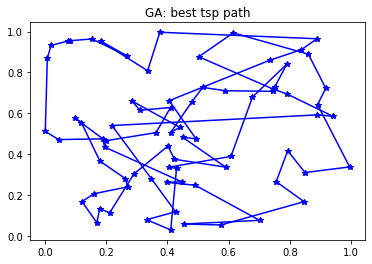

In [141]:
tsp_size = [75, 75, 75]
group_size = [100, 200, 300]
iterations = [800, 800, 800]

# group_size 测试
test = testmodule()
test.GA_perf_test(group_size, iterations, tsp_size, savefolder='./figure/')
# test.GA_perf_test(group_size, iterations, tsp_size, merge=True, mergesave='./figure/GA_groupsize_test_50_50100200_300.jpg')


05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 734.4552664756775


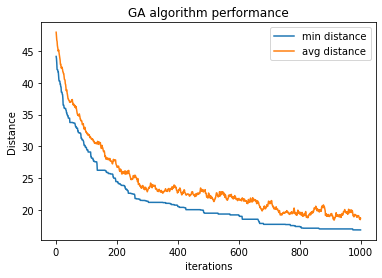

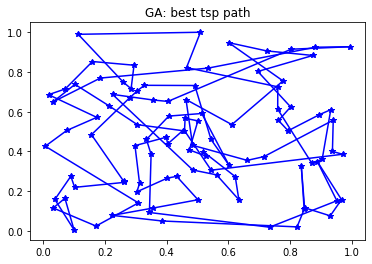

In [138]:
tsp_size = [100]
group_size = [200]
iterations = [1000]

# min_dist 与 avg_dist的一致性测试
test = testmodule()
test.GA_perf_test(group_size, iterations, tsp_size, savefolder='./figure/')


05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 755.4892101287842
05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time: 272.948823928833


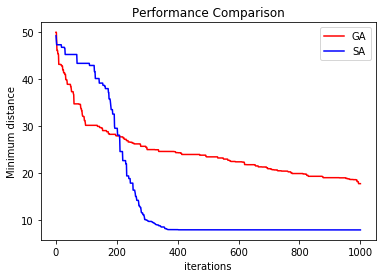

In [91]:
tsp_size, group_size, iterations = 100, 200, 1000
# 比较GA SA
test = testmodule(size=tsp_size)
test.compare_GASA_test(group_size, iterations, './figure/Compare_GASA_test_{0:}_{1:}_{2:}_1.jpg'.format(tsp_size, group_size, iterations))


05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 158.12723517417908
05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 134.40041708946228
05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 161.2237594127655


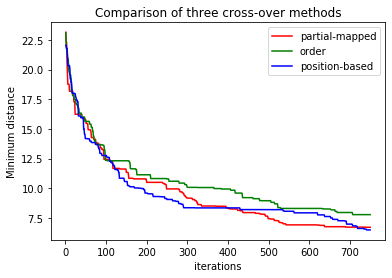

In [98]:
tsp_size, group_size, iterations, number = 50, 100, 750, 1
# 比较三种交叉策略
test = testmodule(size=tsp_size)
test.GA_cross_method_test(group_size, iterations, './figure/cross_method_test_{0:}_{1:}_{2:}_{3:}.jpg'.format(tsp_size, group_size, iterations, number))

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 747.9152131080627
05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 742.7586297988892


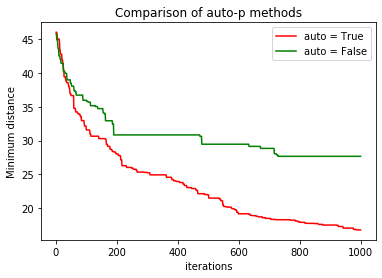

In [99]:
tsp_size, group_size, iterations, number = 100, 200, 1000, 1
# 比较自适应策略
test = testmodule(size=tsp_size)
test.GA_auto_test(group_size, iterations, './figure/GA_auto_test_{0:}_{1:}_{2:}_{3:}.jpg'.format(tsp_size, group_size, iterations, number))

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
run time = 934.1265108585358


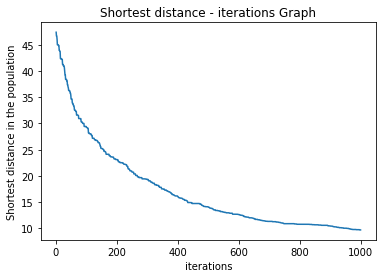

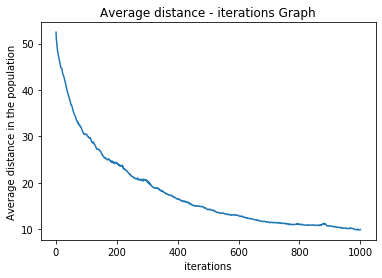

In [146]:
methods = ['partial-mapped', 'order', 'position-based']
# k = (0.4, 0.3, 0.3, 0.1)
tsp_size = 100
group_size = 200
dots = np.random.rand(2, tsp_size)
tsp = tsp_genetic(dots, group_size = group_size)
record, dist, res = tsp.evolute(1000, method=methods[0])
tsp.plot_record(1, './figure/min_dist_100_200_1000_1.jpg')
tsp.plot_record(2, './figure/avg_dist_100_200_1000_1.jpg')


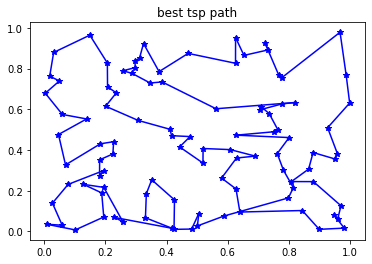

minimum distance: 9.060289547129564


In [191]:
tsp.plot_cities(res, './figure/best_path_100_200_2000_1')
print('minimum distance: {}'.format(tsp.min_rec[-1]))

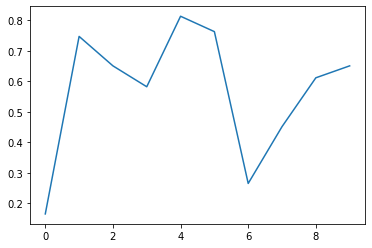

In [153]:
plt.figure()
x = np.arange(10)
y = np.random.rand(3,10)
plt.plot(x,y[0])
plt.show()

In [20]:
x = np.arange(10)
x = x.reshape(1,-1)
print(x,x.shape)
y = np.repeat(x, 5, axis = 0)
print(y

[[0 1 2 3 4 5 6 7 8 9]] (1, 10)
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]


In [12]:
tsp_size = 100
group_size = 100
dots = np.random.rand(2, tsp_size)
tsp = tsp_genetic(dots, group_size = group_size)

05% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 
run time = 356.29847145080566


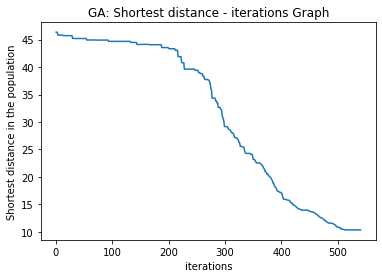

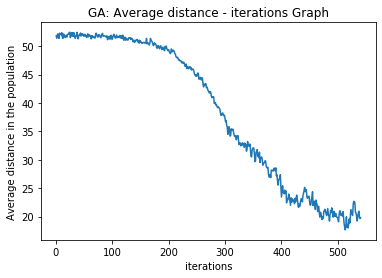

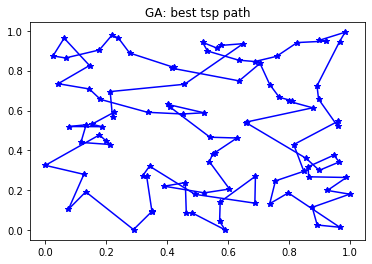

In [15]:
record, dist, res = tsp.evolute(20, SA=True)
tsp.plot_record(1)
tsp.plot_record(2)
tsp.plot_cities()